In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

Connecting anneurai@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as anneu


In [75]:
## GET WEIGHT AND WATER DATA FOR ALL IBL SUBJECTS
subj = subject.Subject * subject.SubjectLab & \
        (subject.SubjectProject & 'subject_project = "ibl_neuropixel_brainwide_01"') 
weight_with_date = subj * action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
# get session with date
b = subj  * avg_weight_date * total_water_date
b = b.proj('subject_nickname', 'sex', 'lab_name', 'avg_weight', 'total_water', 'watertype')

df = pd.DataFrame(b.fetch(as_dict=True))
df = df[~(df['avg_weight'] > 80)] #errors in the database; throw away crazy weights
df = df[~(df['avg_weight'] < 10)] #errors in the database; throw away crazy weights

weight_normalized = pd.DataFrame([])
for index, sjdat in df.groupby(['subject_nickname']):
    sjdat['norm_weight'] = sjdat['avg_weight'] / sjdat['avg_weight'].mean()
    sjdat['days_weight'] = sjdat['session_date'] - sjdat['session_date'].min()
    weight_normalized = weight_normalized.append(sjdat)

df = weight_normalized.copy()

# ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
df['days_weight'] = df['days_weight'].dt.days
df.head(n=10)

/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,subject_uuid,session_date,subject_nickname,sex,lab_name,avg_weight,total_water,watertype,norm_weight,days_weight,week_number,weekday_name
7006,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-10-25,CSHL045,M,churchlandlab,23.000000,NaN,Citric Acid Water 2%,0.952085,2,43,Friday
7007,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-11-07,CSHL045,M,churchlandlab,22.790001,0.8000,Hydrogel,0.943392,15,45,Thursday
7008,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-11-19,CSHL045,M,churchlandlab,23.740000,1.2360,Water 10% Sucrose,0.982718,27,47,Tuesday
7009,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-12-03,CSHL045,M,churchlandlab,24.020000,1.2264,Water 10% Sucrose,0.994308,41,49,Tuesday
7010,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-12-13,CSHL045,M,churchlandlab,24.350000,1.0488,Citric Acid Water 2%; Water 10% Sucrose,1.007969,51,50,Friday
7011,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-12-27,CSHL045,M,churchlandlab,25.230000,0.8118,Citric Acid Water 2%; Water 10% Sucrose,1.044396,65,52,Friday
7012,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2020-01-13,CSHL045,M,churchlandlab,25.290001,0.8070,Water 10% Sucrose,1.046880,82,3,Monday
7013,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2020-01-24,CSHL045,M,churchlandlab,24.260000,1.2825,Citric Acid Water 2%; Water 10% Sucrose,1.004243,93,4,Friday
7014,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2020-02-05,CSHL045,M,churchlandlab,24.180000,1.5270,Water 10% Sucrose,1.000931,105,6,Wednesday
7015,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2020-02-17,CSHL045,M,churchlandlab,26.670000,0.8250,Water 10% Sucrose,1.104005,117,8,Monday


In [76]:

# # ensure that the reference weight is also added
# restrictions = pd.DataFrame.from_dict((action.WaterRestriction * subject.Subject * subject.SubjectLab &
# 'subject_nickname="%s"'%mousename & 'lab_name="%s"'%labname).fetch(as_dict=True))
# restr_summary = restrictions[['restriction_start_time', 'reference_weight']].copy()
# restr_summary = restr_summary.rename(columns = {'restriction_start_time':'date_time', 'reference_weight':'weight'})


In [83]:
# FOR EACH LAB, WHAT'S THE 
lab_watermap = {}
for name, group in df.groupby(['lab_name']):
    #print(name)
    #print(group.watertype.unique())
    matching = [s for s in group.watertype if "Citric" in s]
    if not len(matching) == 0:
        lab_watermap.update({name:'CA'})
    else:
        lab_watermap.update({name:'restr'})

df['weekend_water_regime'] = df['lab_name'].map(lab_watermap)
df.weekend_water_regime.unique()
df

,subject_uuid,session_date,subject_nickname,sex,lab_name,avg_weight,total_water,watertype,norm_weight,days_weight,week_number,weekday_name,weekend_water_regime
7006,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-10-25,CSHL045,M,churchlandlab,23.000000,NaN,Citric Acid Water 2%,0.952085,2,43,Friday,CA
7007,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-11-07,CSHL045,M,churchlandlab,22.790001,0.8000,Hydrogel,0.943392,15,45,Thursday,CA
7008,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-11-19,CSHL045,M,churchlandlab,23.740000,1.2360,Water 10% Sucrose,0.982718,27,47,Tuesday,CA
7009,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-12-03,CSHL045,M,churchlandlab,24.020000,1.2264,Water 10% Sucrose,0.994308,41,49,Tuesday,CA
7010,b04fd8a4-1ba4-4bc2-9593-238386281a6c,2019-12-13,CSHL045,M,churchlandlab,24.350000,1.0488,Citric Acid Water 2%; Water 10% Sucrose,1.007969,51,50,Friday,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4878,76273386-e6a3-4b91-a5fe-a10264b67bb0,2020-03-10,ibl_witten_24,F,wittenlab,18.400000,0.7770,Water 10% Sucrose,1.006381,1,11,Tuesday,restr
4879,76273386-e6a3-4b91-a5fe-a10264b67bb0,2020-03-11,ibl_witten_24,F,wittenlab,18.299999,0.8550,Water 10% Sucrose,1.000912,2,11,Wednesday,restr
4880,76273386-e6a3-4b91-a5fe-a10264b67bb0,2020-03-12,ibl_witten_24,F,wittenlab,18.700001,0.7890,Water 10% Sucrose,1.022789,3,11,Thursday,restr
4881,76273386-e6a3-4b91-a5fe-a10264b67bb0,2020-03-13,ibl_witten_24,F,wittenlab,18.000000,1.1977,Water 10% Sucrose,0.984503,4,11,Friday,restr


In [ ]:
# g = sns.FacetGrid(df, col="lab_name", hue='subject_nickname', col_wrap=4, xlim=[0, 100])
# g.map(sns.lineplot, 'days_weight', 'avg_weight', marker='.')

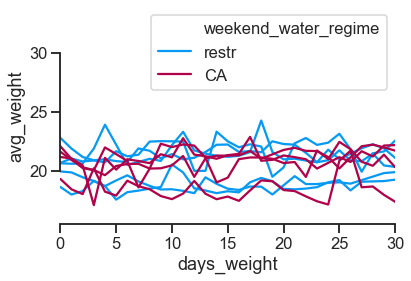

In [105]:
condition_order = [ "restr", "CA"]
palette = sns.xkcd_palette(['azure', 'raspberry'])

df_group = df.groupby(['lab_name', 'days_weight', 'weekend_water_regime'])['avg_weight'].mean().reset_index()
f = sns.lineplot(data=df_group, x='days_weight', y='avg_weight', hue='weekend_water_regime', 
                 units='lab_name', estimator=None, palette=palette, hue_order=condition_order)
#f = sns.lineplot(data=df_group, x='days_weight', y='avg_weight', hue='weekend_water_regime')
f.set_xlim([0, 30])
sns.despine(trim=True)

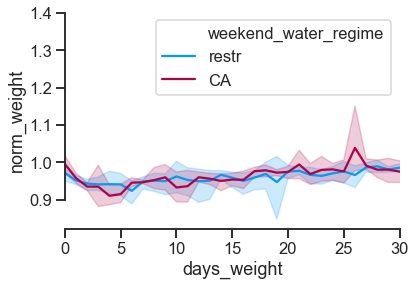

In [108]:
df_group = df.groupby(['lab_name', 'days_weight', 'weekend_water_regime'])['norm_weight'].mean().reset_index()
f = sns.lineplot(data=df_group, x='days_weight', y='norm_weight', hue='weekend_water_regime', 
                 palette=palette, hue_order=condition_order)
#f = sns.lineplot(data=df_group, x='days_weight', y='avg_weight', hue='weekend_water_regime')
f.set_xlim([0, 30])
sns.despine(trim=True)